In [1]:
import netCDF4 as nc

import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

from scipy import signal
import scipy
from inspect import signature

In [2]:
path = '/Users/zcaspar/codes/Diagnostics/'

In [3]:
corrL = {}
removed = ['avg1d','nada']
for name,data in zip(removed,['ZC_drifters_corr_40avg1d.nc','ZC_drifters_corr_40total.nc']):
    corrL[name] = xr.open_dataset(path+data)
    for v in ['uu', 'vv']:
        corrL[name][v+'_normalized'] = corrL[name][v]/corrL[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrL[name][v+'_normalized'] = corrL[name][v]/np.sqrt(corrL[name]['uu'].sel(lag=0)*corrL[name]['vv'].sel(lag=0))

In [4]:
corrE = {}
removed = ['avg1d','nada']
for name,data in zip(removed,['ZC_Eulerian_corr_40avg1d.nc','ZC_Eulerian_corr_40total.nc']):
    corrE[name] = xr.open_dataset(path+data).rename({'lags':'lag'})
    for v in ['uu', 'vv']:
        corrE[name][v+'_normalized'] = corrE[name][v]/corrE[name][v].sel(lag=0)
    for v in ['uv', 'vu']:
        corrE[name][v+'_normalized'] = corrE[name][v]/np.sqrt(corrE[name]['uu'].sel(lag=0)*corrE[name]['vv'].sel(lag=0))

## Model fit : 

In [53]:
om = 2 # tidal frequency (M2)
# Fast contribution
def Ctilde(t,Tt):
    return np.exp(-t/Tt)*np.cos(2*np.pi*om*t)#*np.cos(2*np.pi*nu*t)
#Slow contribution
def Cbar(t,Tb,Om):
    return np.exp(-t/Tb)*np.cos(2*np.pi*Om*t)
#Total formula
def C(t,Tt,Xtilde,Tb,Xbar,Omega):
    return Xbar*Cbar(t,Tb,Omega)+Xtilde*Ctilde(t,Tt)

#### Notes : 
For now, the node is not fitted (no explaination and fit more difficult for the tot£al signal)

In [51]:
def fit(t,y,myfunc,bounds,norm=False): 
    """Compute the best fit parameters found using scipy.optimize.curve_fit
        Parameters
        ----------
        t : timelag of the correlation function
        y : data to fit
        myfunc : function we want to fit to our data, y
        bounds : bounds of the parameters to fit 
        
        Returns
        ----------
        yfit : best fit
        params : parameters for which we obtain the best fit
        cov : covariance of params computed in scipy.optimize.curve_fit
        """
    sig = signature(myfunc)
    if norm:
        y = y/y.sel(lag=0)
    if np.isnan(y).any()==True:
        yfit = np.full_like(y,np.nan)
        params=np.full(len([V for V in sig.parameters.keys()][1:]),np.nan)
        cov = np.full((len([V for V in sig.parameters.keys()][1:]),len([V for V in sig.parameters.keys()][1:])),np.nan)
        yfit = xr.DataArray(np.full(y.lag.size,np.nan))
    else : 
        params,cov = scipy.optimize.curve_fit(myfunc,t,y,bounds=bounds)#,sigma=weights,absolute_sigma=True)
        yfit = myfunc(t,*[p for p in params])
    out = xr.Dataset({'params':(['ybin','param'],np.expand_dims(params, axis=0)),
                      'fitted':(['ybin','lags'],np.expand_dims(yfit.values,axis=0))},
                     coords={'ybin':np.array([y.y_bins.values]),'param':[V for V in sig.parameters.keys()][1:],
                             'lags':y.lag.values})
    return out#yfit,params,cov

In [54]:
out = fit(corrL['avg1d']['uu'].lag,corrL['avg1d']['uu'].sel(y_bins=1500,method='nearest'),C,(0,np.inf),False)



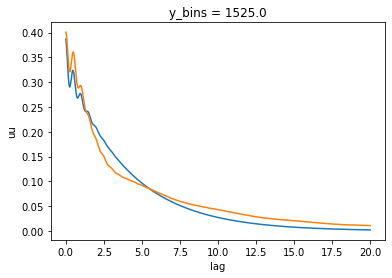

In [57]:
out.fitted.plot()
corrL['avg1d']['uu'].sel(y_bins=1500,method='nearest').plot()

In [70]:
# Parameters
myfunc = C
bounds = (0,(40,np.inf,40,np.inf,1))

###  Average 1d removed to signal

In [71]:
out_combL_avg = xr.concat([fit(corrL['avg1d']['uu'].lag,corrL['avg1d']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,False) for Y in corrL['avg1d']['uu'].y_bins],dim='ybin')
out_combE_avg = xr.concat([fit(corrE['avg1d']['uu'].lag,corrE['avg1d']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,False) for Y in corrE['avg1d']['uu'].y_bins],dim='ybin')

In [72]:
out_combE_avg = out_combE_avg.assign_coords({'ybin':out_combE_avg.ybin.values*1e-3})

In [96]:
# Parameters plot
lims = [(0,25),(0,0.55),(0,25),(0,0.55),(-0.01,0.05)]
titles = [r'$\widetilde{T}$',r'$\widetilde{X}$',r'$\overline{T}$',r'$\overline{X}$',r'$\Omega$']

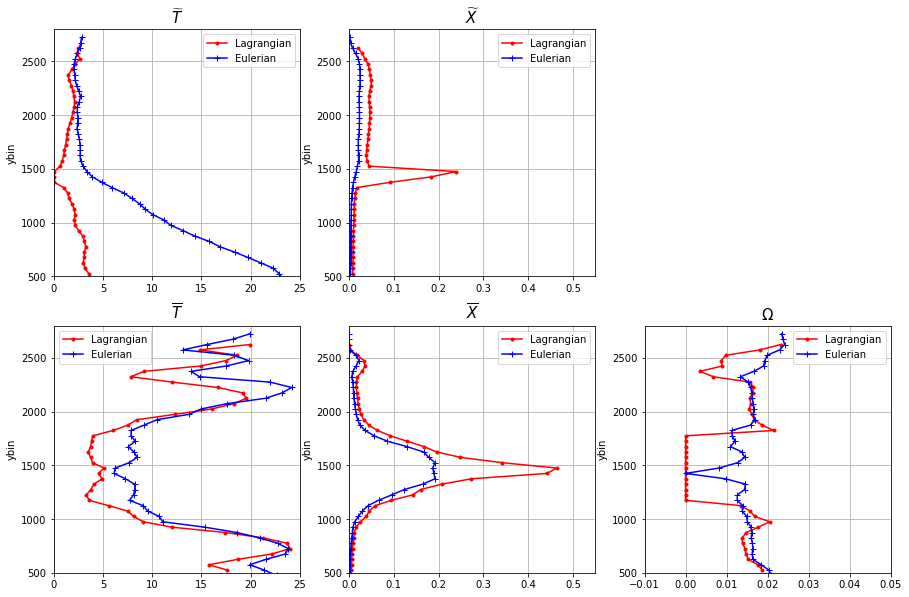

In [97]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg.params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims[2:],axes[1,:]):
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE_avg.params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])

### Total

In [74]:
out_combL = xr.concat([fit(corrL['nada']['uu'].lag,corrL['nada']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,False) for Y in corrL['nada']['uu'].y_bins],dim='ybin')

In [75]:
out_combE = xr.concat([fit(corrE['nada']['uu'].lag,corrE['nada']['uu'].sel(y_bins=Y,method='nearest'),
                          myfunc,bounds,False) for Y in corrE['nada']['uu'].y_bins],dim='ybin')

In [76]:
out_combE = out_combE.assign_coords({'ybin':out_combE.ybin.values*1e-3})

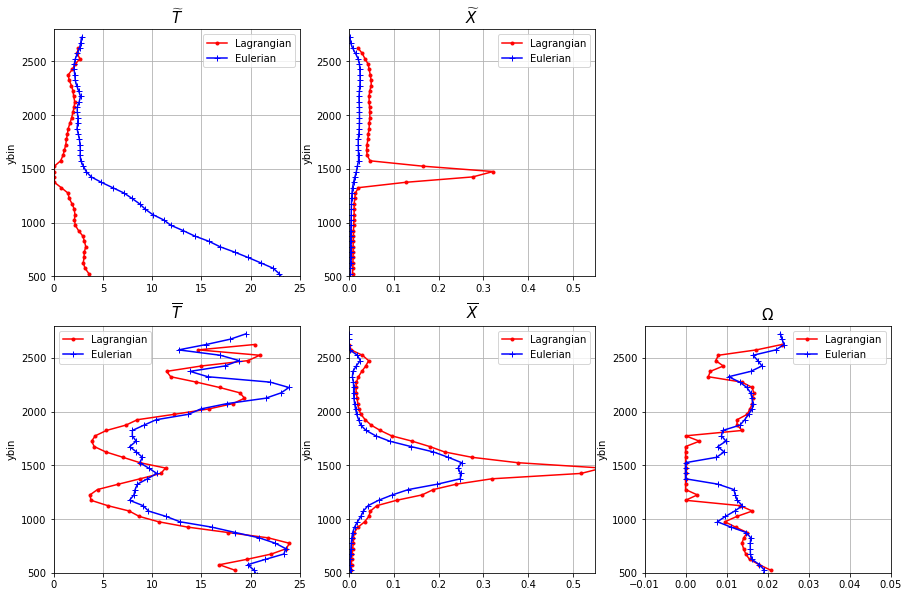

In [98]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE.params.sel(param=pa).plot(y='ybin',c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims[2:],axes[1,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='r',ax=ax,marker='.',label='Lagrangian')
    out_combE.params.sel(param=pa).plot(y='ybin', c='b',ax=ax,marker='+',label='Eulerian')
    ax.set_ylim(500,2800);ax.set_xlim(lim);ax.set_xlabel('')
    ax.legend();ax.grid();ax.set_title(title,fontsize=15)
fig.delaxes(axes[0,2])

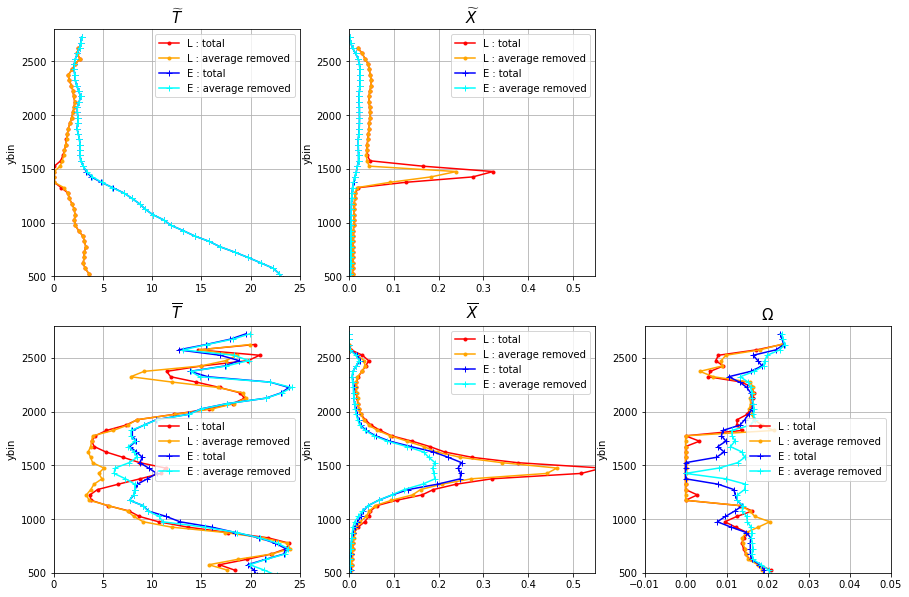

In [100]:
fig,axes = plt.subplots(2,3,figsize=(15,10))
for pa,title,lim,ax in zip(['Tt','Xtilde'],titles[:2],lims[:2],axes[0,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE.params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg.params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
for pa,title,lim,ax in zip(['Tb','Xbar','Omega'],titles[2:],lims[2:],axes[1,:]):
    out_combL.params.sel(param=pa).plot(y='ybin',c='red',ax=ax,marker='.',label='L : total')
    out_combL_avg.params.sel(param=pa).plot(y='ybin',c='orange',ax=ax,marker='.',label='L : average removed')
    out_combE.params.sel(param=pa).plot(y='ybin',c='blue',ax=ax,marker='+',label='E : total')
    out_combE_avg.params.sel(param=pa).plot(y='ybin',c='cyan',ax=ax,marker='+',label='E : average removed')
    ax.set_ylim(500,2800);ax.set_title(title,fontsize=15);ax.set_xlim(lim)
    ax.legend();ax.grid();ax.set_xlabel('')
fig.delaxes(axes[0,2])